### Introduction

In [1]:
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Regression

#### Model

First we load the csv created earlier into a data frame and then calculate z-scores for every effect in order to make our logistic regression model accurate and understandable. 

In [2]:
data = pd.read_csv("../../DataSets/balanced_pop_unpop_features.csv", sep=",")
data['title'] = data['Unnamed: 0']
data = data.drop('Unnamed: 0', axis=1)
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,label,title
0,0.21400,0.666,178242,0.677,0.000000,2,0.0979,-5.743,0.0326,100.014,4,0.178,1,#Beautiful
1,0.01340,0.807,183750,0.916,0.000012,0,0.0787,-3.282,0.2260,127.973,4,0.651,1,#SELFIE
2,0.00162,0.791,279507,0.615,0.000065,6,0.0812,-6.149,0.0667,128.017,4,0.393,1,#thatPOWER
3,0.76300,0.707,275227,0.709,0.000000,11,0.2740,-3.979,0.3400,89.094,4,0.501,1,0 To 100 / The Catch Up
4,0.57000,0.629,250173,0.572,0.000000,5,0.1920,-7.733,0.0387,100.015,4,0.386,1,1-800-273-8255


In [3]:
no_title = data.drop(['title', 'label'], axis=1)
z_scores=(no_title - no_title.mean())/no_title.std()
z_scores.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,0.234429,0.153280,-1.087287,-0.034082,-0.111864,-0.924928,-0.569818,0.078899,-0.665590,-0.776052,0.110072,-1.499069
1,-0.744047,1.169892,-0.953584,1.390222,-0.111643,-1.467484,-0.704061,1.114347,1.339700,0.212902,0.110072,0.635067
2,-0.801507,1.054532,1.370844,-0.403567,-0.110689,0.160186,-0.686582,-0.091923,-0.312020,0.214459,0.110072,-0.529007
3,2.912313,0.448891,1.266950,0.156620,-0.111864,1.516578,0.661443,0.821089,2.521722,-1.162309,0.110072,-0.041720
4,1.970908,-0.113491,0.658783,-0.659823,-0.111864,-0.111093,0.088113,-0.758380,-0.602341,-0.776016,0.110072,-0.560590


We will test a few different combinations of effects in order to find a model with the most predictive power. We first run a logistic regression using all of the features, then we chose the three features with the highest impact on the logistic regression that included all features and re-run a regression using only those 3. 

We also test our initial hypothesis that danceability alone will be a good predictor of popularity.

Next, to create another version of this model we calculated the total correlation between all variables and all other variables in order to try and determine which features could be excluded from the next iteration of the model. This lead us to using key, instrumentalness, and duration as the paramaters as these 3 features all had the lowest total correlations as well as low correlation values with each other.

In [4]:
corr = no_title.corr()
total_corr = []
c = 0
for feature in corr:
    ind = 0
    for i in corr[feature]:
        if c == 0:
            total_corr.append(0)
        total_corr[ind] += abs(i)
        ind+=1
    c += 1
print(total_corr)

[2.7329680037073145, 2.1948466714079466, 1.6361565821815707, 3.560806103766256, 1.5099574136833491, 1.273709376402949, 1.786414884476453, 3.264330658962157, 1.9324017245762282, 1.884353906738323, 1.7827839781681039, 2.7386064388550784]


In [5]:
corr

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
acousticness,1.000000,-0.184256,-0.007125,-0.520882,0.069646,-0.003758,-0.066380,-0.419566,-0.036140,-0.146195,-0.104638,-0.174381
danceability,-0.184256,1.000000,-0.083887,-0.041506,0.008108,0.013918,-0.068204,0.057201,0.232517,-0.133679,0.097874,0.273697
duration_ms,-0.007125,-0.083887,1.000000,-0.089369,0.027760,-0.045954,0.056755,-0.090763,-0.018312,-0.004759,-0.025812,-0.185662
energy,-0.520882,-0.041506,-0.089369,1.000000,-0.054364,0.032311,0.171197,0.732734,-0.099753,0.193083,0.182769,0.442839
instrumentalness,0.069646,0.008108,0.027760,-0.054364,1.000000,0.033556,0.001823,-0.212182,-0.022305,0.001817,0.011647,-0.066750
key,-0.003758,0.013918,-0.045954,0.032311,0.033556,1.000000,0.012247,0.008563,0.078638,-0.002376,0.004328,0.038061
liveness,-0.066380,-0.068204,0.056755,0.171197,0.001823,0.012247,1.000000,0.074880,0.150872,0.068766,0.047602,0.067690
loudness,-0.419566,0.057201,-0.090763,0.732734,-0.212182,0.008563,0.074880,1.000000,-0.106264,0.127396,0.143307,0.291474
speechiness,-0.036140,0.232517,-0.018312,-0.099753,-0.022305,0.078638,0.150872,-0.106264,1.000000,0.113213,0.052869,0.021518
tempo,-0.146195,-0.133679,-0.004759,0.193083,0.001817,-0.002376,0.068766,0.127396,0.113213,1.000000,0.014236,0.078833


In order to avoid overfitting in our models, it is necessary to split our data into two separate sets of test and training data.

In [6]:
x_train, x_test, y_train, y_test= train_test_split(z_scores, data['label'])

test_2 = z_scores[['danceability', 'instrumentalness', 'tempo']]
x_train2, x_test2, y_train2, y_test2= train_test_split(test_2, data['label'])

test_3 = z_scores[['key', 'instrumentalness', 'duration_ms']]
x_train3, x_test3, y_train3, y_test3= train_test_split(test_3, data['label'])

test_4 = z_scores['instrumentalness']
test_4 = test_4.reshape(-1, 1)
x_train4, x_test4, y_train4, y_test4= train_test_split(test_4, data['label'])

test_5 = z_scores['danceability']
test_5 = test_5.reshape(-1, 1)
x_train5, x_test5, y_train5, y_test5 = train_test_split(test_5, data['label'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [7]:
clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
predicted_train = clf1.predict(x_train)
predicted_test = clf1.predict(x_test)
print (clf1.coef_, clf1.intercept_)

clf2 = LogisticRegression()
clf2.fit(x_train2, y_train2)
predicted_train2 = clf2.predict(x_train2)
predicted_test2 = clf2.predict(x_test2)
print (clf2.coef_, clf2.intercept_)

clf3 = LogisticRegression()
clf3.fit(x_train3, y_train3)
predicted_train3 = clf3.predict(x_train3)
predicted_test3 = clf3.predict(x_test3)
print (clf3.coef_, clf3.intercept_)

clf4 = LogisticRegression()
clf4.fit(x_train4, y_train4)
predicted_train4 = clf4.predict(x_train4)
predicted_test4 = clf4.predict(x_test4)
print (clf4.coef_, clf4.intercept_)

clf5 = LogisticRegression()
clf5.fit(x_train5, y_train5)
predicted_train5 = clf5.predict(x_train5)
predicted_test5 = clf5.predict(x_test5)
#print(predicted_test5)
print (clf5.coef_, clf5.intercept_)

[[-0.0386039   0.07073096  0.04802809  0.00482995 -0.08410396 -0.02393694
   0.04591933 -0.0174454   0.11860687  0.06639801  0.03054173  0.0098491 ]] [-0.01554774]
[[ 0.15989985 -0.10068883  0.00532568]] [0.01105739]
[[-0.03807051 -0.10847069  0.08211192]] [-0.01981267]
[[-0.12898915]] [-0.01037807]
[[0.07007137]] [0.05073162]


#### Analysis

### Neural Network 

The linear regression yielded poor results, so we thought a more complex regression might lend towards a better analysis. For this we decided to build a neural network using Tensorflow. We chose a feedforward neural network due to its ability to model non linear functions.

We begin by importing the Tensorflow module, which provides a framework for, what seems like, every type of modeling technique. Take note that 'tf' is the industry standard alias for tensorflow.We next need to examine and analyize predictive power of our different models.

Here we see that for every set of predictors, the model is able to predict popularity with an accuracy between 51-53%, while for the test data the amount of variance that can be explained is even lower. None of these logistic regressions are very powerful predictors.

In [8]:
train1_rsq = clf1.score(x_train, y_train)
test1_rsq = clf1.score(x_test, y_test)
print("Training 1-rsq = %f, Testing 1-rsq = %f, all effects" % (train1_rsq, test1_rsq))
    
train2_rsq = clf2.score(x_train2, y_train2)
test2_rsq = clf2.score(x_test2, y_test2)
print("Training 2-rsq = %f, Testing 2-rsq = %f, danceability, instrumentalness, and tempo" % (train2_rsq, test2_rsq))

train3_rsq = clf3.score(x_train3, y_train3)
test3_rsq = clf3.score(x_test3, y_test3)
print("Training 3-rsq = %f, Testing 3-rsq = %f, key, instrumentalness, and duration" % (train3_rsq, test3_rsq))

train4_rsq = clf4.score(x_train4, y_train4)
test4_rsq = clf4.score(x_test4, y_test4)
print("Training 4-rsq = %f, Testing 4-rsq = %f, instrumentalness only" % (train4_rsq, test4_rsq))

train5_rsq = clf5.score(x_train5, y_train5)
test5_rsq = clf5.score(x_test5, y_test5)
print("Training 5-rsq = %f, Testing 5-rsq = %f, danceability only" % (train5_rsq, test5_rsq))

Training 1-rsq = 0.522388, Testing 1-rsq = 0.507463, all effects
Training 2-rsq = 0.548507, Testing 2-rsq = 0.485075, danceability, instrumentalness, and tempo
Training 3-rsq = 0.519900, Testing 3-rsq = 0.507463, key, instrumentalness, and duration
Training 4-rsq = 0.504975, Testing 4-rsq = 0.492537, instrumentalness only
Training 5-rsq = 0.533582, Testing 5-rsq = 0.522388, danceability only


Next we need to calculate the precision and recall of our models in order to better analyize their effectiveness.

In [17]:
def conditions(predicted, actual):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            if predicted[i] == 1:
                TP += 1
            else:
                TN += 1
        else:
            if predicted[i] == 1:
                FP += 1
            else:
                FN += 1
    return(TP, TN, FP, FN)

In [19]:

def precision(TP, FP):
    if TP+FP != 0:
        return(float(TP)/float(TP+FP))
    else:
        return(np.nan)

In [20]:
def recall(TP, FN):
    if TP+FN != 0:
        return(float(TP)/float(TP+FN))
    else:
        return(np.nan)

In [21]:
y_test = list(y_test)
TP1, TN1, FP1, FN1 = conditions(predicted_test, y_test)
print("Test 1 : Precision = %f, Recall = %f" % (precision(TP1,FP1), recall(TP1, FN1)))

y_test2 = list(y_test2)
TP2, TN2, FP2, FN2 = conditions(predicted_test2, y_test2)
print("Test 2 : Precision = %f, Recall = %f" % (precision(TP2,FP2), recall(TP2, FN2)))

y_test3 = list(y_test3)
TP3, TN3, FP3, FN3 = conditions(predicted_test3, y_test3)
print("Test 3 : Precision = %f, Recall = %f" % (precision(TP3,FP3), recall(TP3, FN3)))

y_test4 = list(y_test4)
TP4, TN4, FP4, FN4 = conditions(predicted_test4, y_test4)
print("Test 4 : Precision = %f, Recall = %f" % (precision(TP4,FP4), recall(TP4, FN4)))

y_test5 = list(y_test5)
TP5, TN5, FP5, FN5 = conditions(predicted_test5, y_test5)
print("Test 5 : Precision = %f, Recall = %f" % (precision(TP5,FP5), recall(TP5, FN5)))

Test 1 : Precision = 0.519231, Recall = 0.397059
Test 2 : Precision = 0.478873, Recall = 0.515152
Test 3 : Precision = 0.528302, Recall = 0.405797
Test 4 : Precision = 0.497976, Recall = 0.911111
Test 5 : Precision = 0.490196, Recall = 0.806452


Above we can see that the precsion of all of our models is not very high, that is that we have a similar number of true positives as false positives, while the recall of each model has a very large range. Model 4 has by far the highest recall, meaning that there were very few false negatives when using that model: i.e. songs that the model thought would not be popular but were actually popular. This model is likely due to the property that this model predicts that almost all songs will be popular.

#### Visualizations

-0.12898915437479477 -0.010378074549077188


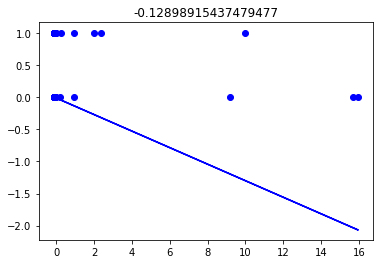

In [22]:
x = x_test4
y = y_test4
#line = matplotlib.lines.Line2D(clf4.coef_, clf4.intercept_)
plt.scatter(x, y, c='b')
slope = clf4.coef_[0][0]
intercept = clf4.intercept_[0]
print(slope, intercept)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in x]
# Plot the best fit line over the actual values
plt.plot(x, abline_values, 'b')
plt.title(slope)
plt.show()

### Neural Network 

-blah

In [24]:
import tensorflow as tf


Next, we read in the balanced song features dataset, which includes data on every song that has appeared on the Billboard Hot 100 since 2010. Intially the dataset was split such that 70% of the music was unpopular and 30% popular. After completing the training the network had an outstanding 70% accuracy! Under further investigation, we realized the networks was simply assigning everything an unpopular label. Do remedy this we modified our dataset such that there was a 50-50 split between popular and unpopular songs. 

In [11]:
#Read in File
data = pd.read_csv("balanced_pop_unpop_features.csv")

#Remove track name column
del data["Unnamed: 0"]

#Quick look at the data
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,label
0,0.21400,0.666,178242,0.677,0.000000,2,0.0979,-5.743,0.0326,100.014,4,0.178,1
1,0.01340,0.807,183750,0.916,0.000012,0,0.0787,-3.282,0.2260,127.973,4,0.651,1
2,0.00162,0.791,279507,0.615,0.000065,6,0.0812,-6.149,0.0667,128.017,4,0.393,1
3,0.76300,0.707,275227,0.709,0.000000,11,0.2740,-3.979,0.3400,89.094,4,0.501,1
4,0.57000,0.629,250173,0.572,0.000000,5,0.1920,-7.733,0.0387,100.015,4,0.386,1


In [12]:
print(len(data.columns))

13


The Tensorflow software below automatically shuffles the data, but just to be sure the following line of code mixes up the rows of the dataframe.


In [13]:
#Shuffle dataset
for i in range(10): data = data.sample(frac=1)
    
#Quick look at the shuffled data
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,label
666,0.261,0.675,226507,0.545,0.000000,7,0.1620,-5.614,0.0443,60.048,4,0.445,0
280,0.328,0.508,227280,0.677,0.000000,1,0.0491,-5.696,0.0656,121.928,5,0.575,1
665,0.139,0.845,256027,0.576,0.000000,11,0.0764,-5.150,0.1530,127.641,4,0.461,0
252,0.121,0.733,142000,0.678,0.000000,6,0.3440,-7.771,0.4380,175.985,4,0.841,1
726,0.238,0.668,322549,0.678,0.000006,0,0.5270,-8.015,0.0496,132.584,4,0.778,0


#### Model 

To model the data, the data is split 70-30, where 70% of the data is used to train the model and 30% of the data is used to test the model. 

In [14]:
#About a 70-30 split between training and testing 
train = data.iloc[:750]
test = data.iloc[750:]

#Quick look at shape of the two sets
print(train.shape,test.shape)

(750, 13) (322, 13)


Next, the training and test sets are split into sets of features and labels. Immedietly following, the sets are normalized using a Z-score.

In [15]:
#Split entries in train_x: features and train_y: labels
train_x = train.iloc[:,:12]
train_y = train.iloc[:,12:].astype(int)

test_x = test.iloc[:,:12]
test_y = test.iloc[:,12:].astype(int)

#Take Z-score
train_x = (train_x-train_x.mean())/(train_x.std())
test_x = (test_x-test_x.mean())/(test_x.std())

#Quick look at training set
train_x.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
666,0.427804,0.236938,0.096808,-0.789682,-0.112147,0.450061,-0.143541,0.153042,-0.565808,-2.184712,0.087686,-0.308318
280,0.751057,-0.967414,0.115479,-0.014643,-0.112147,-1.183225,-0.912828,0.118104,-0.351855,-0.023579,3.548960,0.280119
665,-0.160805,1.462924,0.809839,-0.607666,-0.112147,1.538919,-0.726809,0.350742,0.526058,0.175945,0.087686,-0.235895
252,-0.247649,0.655215,-1.944390,-0.008771,-0.112147,0.177847,1.096585,-0.766007,3.388815,1.864340,0.087686,1.484149
726,0.316837,0.186456,2.416624,-0.008771,-0.111984,-1.455440,2.343525,-0.869970,-0.512571,0.348578,0.087686,1.198984


Tensorflow requires that a list of column features be provided in order to specify the type of input. The neural network is capable of using other feature types other than numeric.

In [16]:
#Create feature column for net 
feature_columns = []
for i in train_x.columns:
    feature_columns.append(tf.feature_column.numeric_column(key=i))

#Little preview of the numeric_column object
for i in feature_columns[:2]:
    print(i,"\n")

NameError: name 'tf' is not defined

The following code is used to create the neural network. We decided to use a single hidden layer with 5 nodes.

In [ ]:
#Make estimator/ Model

my_checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_secs = 4,  # Save checkpoints every 20 minutes.
    keep_checkpoint_max = 10,       # Retain the 10 most recent checkpoints.
)

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns
                                        , hidden_units=[5],
                                        n_classes=2,model_dir="./modeldata",
                                       config=my_checkpointing_config)

The following function is used to prepare the data for input to the neural network. It is covered in depth in the Tensorflow documentation.

In [ ]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

Next, the network is training using the entirety of the training set. The Batch size is 500 and the number of steps or epochs is 1500.

In [ ]:
# Train the Model.
classifier.train(
    input_fn=lambda:train_input_fn(train_x, train_y,300),
    steps=1000)

#### Analysis

Now that the network is trained it is time to test it with the testing set. The following function prepares the testing set for testing. 

In [ ]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

The following code runs the testing evaluate function on the network.

In [ ]:
# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=lambda:eval_input_fn(test_x, test_y, 3000))

Here are the results of the evaluation more clearly.

A print out of the prediction and exprected results can be found in the ANN Tests document located in the Model folder as well as a series of test done with other features and varying network shapes. 

From the evaluator it's clear that the neural network does a pretty bad job of modeling the data. We believe that to predict whether a song will be popular or not requires atleast some data on the cultural climate at the time. After reading a series of documents written by people conducting the same test, they also agree that analyzing a song's features is insufficient for producing meaningfull predictions. 

### Conclusion

In the end, the modeling portion of this project was unsuccesful. You have an equally good chance of geussing whether a song will be popular or not than counting on our models prediction. We believe that the song features themselves have little to do with the popularity of a song. The prevoius success rate of the artists and the cultural climate play into a songs popularity more so than the song itself. This phenomon can be observed when an artists drops an album in the morning and in the afternoon the entire album appears in the Hot 100. 